In [1]:
from scipy import sparse

import numpy as np
import pandas as pd
import xgboost as xgb

# 读入数据

In [5]:
column=pd.read_csv('./shuchu/index.csv')
index=list(column["0"])
index.remove('id')
index.remove('label')

train_x=sparse.load_npz('./data/train_x_sparse.npz')
train_x=pd.DataFrame(train_x.toarray(),columns=index)
train_y=train_x.tag
train_x.drop('tag',axis=1,inplace=True)
train_x=sparse.csc_matrix(train_x)

test_x=sparse.load_npz('./data/test_x_sparse.npz')
test_x=pd.DataFrame(test_x.toarray(),columns=index)
test_y=test_x.tag
test_x.drop('tag',axis=1,inplace=True)
test_x=sparse.csc_matrix(test_x)

In [10]:
import time 

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder


from sklearn.cross_validation import train_test_split
params={'booster':'gbtree',
    'objective': 'rank:pairwise',
    'eval_metric':'auc',
    'gamma':0.1,
    'min_child_weight':1.1,
    'max_depth':7,
    'lambda':10,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'colsample_bylevel':0.7,
    'eta': 0.01,
    'tree_method':'exact',
    'seed':1000,
    'nthread':12
    }
plst = list(params.items())

def mxgboost(train_x,train_y,test_x,test_y,plst):
    xgb_train = xgb.DMatrix(train_x, label=train_y)
    xgb_test = xgb.DMatrix(test_x, label=test_y)
    del(train_x,train_y,test_x,test_y)
    watchlist = [(xgb_train, 'train'),(xgb_test, 'val')]
    model=xgb.train(plst, xgb_train,num_boost_round=100,evals=watchlist,early_stopping_rounds=5)
    return model
def mpre_xgb(model,data):
    xgb_data=xgb.DMatrix(data)
    return model.predict(xgb_data)


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
model_tag=mxgboost(train_x,train_y,test_x,test_y,plst)

[0]	train-auc:0.972273	val-auc:0.970796
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 5 rounds.
[1]	train-auc:0.976784	val-auc:0.974354
[2]	train-auc:0.976563	val-auc:0.973734
[3]	train-auc:0.975847	val-auc:0.972374
[4]	train-auc:0.975705	val-auc:0.971955
[5]	train-auc:0.976841	val-auc:0.973372
[6]	train-auc:0.976203	val-auc:0.972712
Stopping. Best iteration:
[1]	train-auc:0.976784	val-auc:0.974354



In [11]:
model_tag.save_model('xgb_tag_pre.model')

In [2]:
from sklearn.externals import joblib
model_tag=xgb.Booster(model_file='xgb_tag_pre.model')

In [13]:
pre_tag_test=mpre_xgb(model_tag,test_x)

In [14]:
pre_tag_test

array([0.55978817, 0.47555846, 0.55978817, ..., 0.5506841 , 0.4668457 ,
       0.45301744], dtype=float32)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

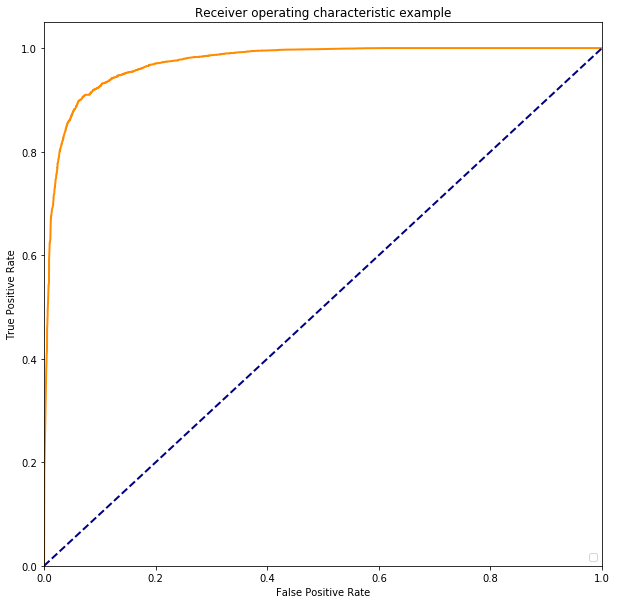

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds  =  roc_curve(test_y, pre_tag_test) 
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [43]:
a=(tpr[1:]-tpr[:-1])/(fpr[1:]-fpr[:-1])
b=thresholds[1:]*(a>0.9)*(a<1.09)
np.mean(b[b>0])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


0.47992188

In [ ]:
import time, datetime
test_online=pd.read_table("test.txt")
def t(d):
    timeStamp=np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        timeArray = time.strptime(d[i], "%Y-%m-%d")
        #print(timeArray)     
        # 转为时间戳
        timeStamp[i] = (int(time.mktime(timeArray))//86400)
        #print (timeStamp)  # 1381419600
    #print(timeStamp)
    return timeStamp-17256.0
test_online.loan_dt=t(test_online.loan_dt)
def queshi(d):
    缺失=np.isnan(d[:]).sum(axis=1)
    d['queshi']=round(((缺失-min(缺失))/(max(缺失)-min(缺失)))*10)
queshi(test_online)
test_online=test_online.drop(['id'],axis=1)

In [7]:
column=pd.read_csv('./shuchu/index.csv')
index=list(column["0"])
index.remove('id')
index.remove('label')
index.remove('tag')
index.remove('year')
index.remove('mon')
index.remove('mday')
index.remove('wday')

test_online=test_online[index]
test_online=sparse.csc_matrix(test_online)

In [8]:
test_online.shape

(20000, 6812)

In [11]:
pre_tag=mpre_xgb(model_tag,test_online)

In [14]:
sum(pre_tag<0.47992188)

1540

In [15]:
sum(pre_tag>0.67992188)

0

In [60]:
v_id=pd.read_table("valid_id.txt")
f2=pd.DataFrame(columns=["id","prob"])
f2.prob=pre_tag
f2.id=v_id
#print(f)
f2.to_csv("./shuchu/re_tag.csv",encoding="utf-8")

In [3]:
w=pd.read_csv("./shuchu/re_tag.csv")

(array([   65.,   429.,   570.,   344.,   343.,   458.,   601.,  1211.,
         3026., 12953.]),
 array([0.43573907, 0.44873349, 0.46172791, 0.47472232, 0.48771674,
        0.50071116, 0.51370558, 0.5267    , 0.53969441, 0.55268883,
        0.56568325]),
 <a list of 10 Patch objects>)

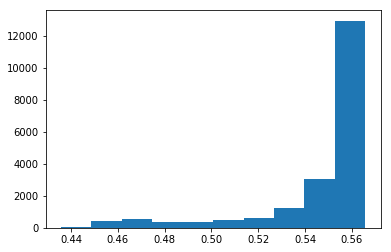

In [6]:
import matplotlib.pyplot as plt
plt.hist(w.prob)


In [9]:
np.percentile(w.prob,5)

0.4719446845